# Neural Net Asset-Type Classifier
As a result of previous trials as well as insights drawn from a completed Support Vector Machine Directional Classifier, and GARCH/ARIMA modeling of the following asset classes: S&P500, Gold, EUR/USD, USD/JPN, CBND, TBND, I will attempt to make a classifier, this time into simply four classes (dropping USD/JPN, and CBND - as a result of poor GARCH and ARIMA, as well as poor SVM performance and in order to simplify the model outputs and speed up the learning process).

I will be using the following features from my dataset:
1. Logged Returns over 20 days (1-month)
2. Normalized Trade Volumes over 20 days
3. Residual Outputs from an ARIMA Forecasting Model over 20 days

The reason behind the use of 20-days is because it performed well in the SVM Classifier, as well as its interpretability of a month's returns. 

In [7]:
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 
import pandas as pd

In [8]:
ret_vol = pd.read_csv("Final_Data.csv")
arima_res = pd.read_csv("ResidualARIMAData.csv")
ret_vol.set_index('Date', inplace = True)
arima_res.set_index('Date', inplace = True)
ret_vol.drop(ret_vol.tail(1).index,inplace = True)
print("Return Vol Dates:",ret_vol.index[0],ret_vol.index[-1])
print("Return Vol Shape", ret_vol.shape)
print("Arima Res Dates:",arima_res.index[0],arima_res.index[-1])
print("Arima Res Shape", arima_res.shape)

Return Vol Dates: 2004-11-19 2019-04-17
Return Vol Shape (3626, 12)
Arima Res Dates: 2004-11-19 2019-04-17
Arima Res Shape (3626, 6)


I will independently build each column (row of 20 days) in a data_matrix (np array). Then hstack the three layers together, with asset classes stacked on top of each other. 

In [9]:
drop_columns = ['USD_Close','USD_Volume','CBND_Close','CBND_Volume']
drop_columns_arima = ['USD_Close','CBND_Close']
ret_vol.drop(drop_columns,inplace = True, axis = 1)
arima_res.drop(drop_columns_arima,inplace = True,axis = 1)
ret_vol.shape

(3626, 8)

In [10]:
#For Returns and Volume
num_days = 20
data_dict = {}
for column in ret_vol:
    col_array = ret_vol[column].values
    data_matrix = np.zeros((ret_vol.shape[0] - num_days + 1)*num_days).reshape((ret_vol.shape[0] - num_days + 1,num_days))
    for i in range(0, ret_vol.shape[0] - num_days + 1):
        data_matrix[i,:] = col_array[i:i+num_days]
    data_dict[column] = data_matrix

In [11]:
#Same for ARIMA Residuals
for column in arima_res:
    col_array = arima_res[column].values
    data_matrix = np.zeros((arima_res.shape[0] - num_days + 1)*num_days).reshape((arima_res.shape[0] - num_days + 1,num_days))
    for i in range(0, arima_res.shape[0] - num_days + 1):
        data_matrix[i,:] = col_array[i:i+num_days]
    data_dict[column + ' Arima'] = data_matrix

In [21]:
#Time to hstack
asset_dict = {}
asset_dict['snp'] = np.hstack((data_dict['SNP_Close'],data_dict['SNP_Volume'],data_dict['SNP_Close Arima']))
asset_dict['gld'] = np.hstack((data_dict['GLD_Close'],data_dict['GLD_Volume'],data_dict['GLD_Close Arima']))
asset_dict['eur'] = np.hstack((data_dict['EUR_Close'],data_dict['EUR_Volume'],data_dict['EUR_Close Arima']))
asset_dict['tbnd'] = np.hstack((data_dict['TBND_Close'],data_dict['TBND_Volume'],data_dict['TBND_Close Arima']))

In [24]:
#Time to stack on top of one another to create the final array
fin_data = np.vstack((asset_dict['snp'],asset_dict['eur'],asset_dict['gld'],asset_dict['tbnd']))

In [47]:
#Creating the Dependent Output Variable of shape [0,0,0,1] etc.
#This is pretty simple because we have stacked the data in order
class_num = 4
fin_dep = np.zeros(fin_data.shape[0]*class_num).reshape(fin_data.shape[0],4)
occur = 0
for j in range(class_num):
    fin_dep[data_matrix.shape[0]*j:data_matrix.shape[0]*(j+1),j] = 1

In [55]:
#Checking to see that all rows sum correctly
for j in range(class_num):
    print(np.sum(fin_dep[:,j]))

3607.0
3607.0
3607.0
3607.0


# Code for Neural Network

Here we will be trying to do a few differnt things. Because the Neural Network code is so modular, we can experiment with a few different things.

Exploring Activation Functions:
    1. Sigmoid
    2. TanH
    3. ReLu

Exploring the structure of the Layers. As a result of a lack of time and computing power, we will default to popular rules of thumb for the complexity, debth, etc. of the Neural Network.

We will test the data on a train-test split of 0.8/0.2 (not the largest but we do not have a very large dataset when it comes to neural nets, so we will have to make due). In addition, as the final goal is to run the NN as a bitcoin asset classifier, I am comfortable with some level of overfitting.

In [152]:
Model_Params = {}
Accuracy = {}
Model_Test_Classification = {}

In [171]:
#Starting by building the simple sigmoid Neural Network
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

In [58]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l],nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [59]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l], ))
    return tri_W, tri_b

In [60]:
def feed_forward(x, W, b):
    a = {1: x}
    z = { }
    for l in range(1, len(W) + 1):
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]
        a[l+1] = f(z[l+1])
    return a, z

In [61]:
def calculate_out_layer_delta(y, a_out, z_out):
    return -(y - a_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [62]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambd = 0):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            a, z = feed_forward(X[i, :], W, b)
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l] + lambd*W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return (W, b, avg_cost_func)

def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [172]:
X_train, X_test, y_train, y_test = train_test_split(fin_data,fin_dep,test_size = 0.2)

In [173]:
#We will use the rule of thumb of middle layer being 2/3*input + output
nn_structure = [60,44,4]
Model_Params['Sigmoid'] = train_nn(nn_structure, X_train, y_train, 3000, lambd = 0.0001)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


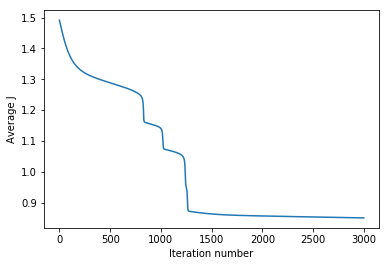

In [174]:
plt.plot(Model_Params['Sigmoid'][2])
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.savefig('First_Neural_Net.png')
plt.show()

In [175]:
W = Model_Params['Sigmoid'][0]
b = Model_Params['Sigmoid'][1]
y_sigm_pred = predict_y(W, b, X_test, 3)
y_sigm_pred_train = predict_y(W, b, X_train, 3)

In [176]:
y_test_vect = np.zeros(y_sigm_pred.shape[0])
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        if y_test[i,j] == 1:
            y_test_vect[i] = j

y_train_vect = np.zeros(y_sigm_pred_train.shape[0])
for i in range(y_train.shape[0]):
    for j in range(y_train.shape[1]):
        if y_train[i,j] == 1:
            y_train_vect[i] = j

In [177]:
print('Prediction accuracy is {}%'.format(accuracy_score(y_test_vect, y_sigm_pred) * 100))
Accuracy['Sigmoid'] = (accuracy_score(y_test_vect, y_sigm_pred),accuracy_score(y_train_vect,y_sigm_pred_train))

Prediction accuracy is 34.71933471933472%


In [93]:
#Prediction accuracy achieved is 33.7837837% 

In [178]:
unique, counts = np.unique(y_sigm_pred, return_counts = True)
class_dict = dict(zip(unique,counts))
Model_Test_Classification['Sigmoid'] = class_dict

# TanH Function

In [179]:
def f(z):
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))

def f_deriv(z):
    return 1. - (f(z))**2

In [180]:
def feed_forward(x, W, b):
    a = {1: x}
    z = { }
    for l in range(1, len(W) + 1):
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]
        a[l+1] = f(z[l+1])
    return a, z

In [181]:
X_train, X_test, y_train, y_test = train_test_split(fin_data,fin_dep,test_size = 0.2)
nn_structure = [60,44,4]
Model_Params['TanH'] = train_nn(nn_structure, X_train, y_train, 3000, lambd = 0.005)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


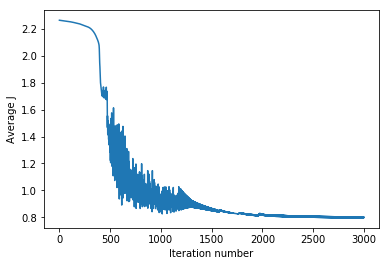

In [183]:
plt.plot(Model_Params['TanH'][2])
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.savefig('First_Neural_Net.png')
plt.show()

In [184]:
W = Model_Params['TanH'][0]
b = Model_Params['TanH'][1]
y_tanH_pred = predict_y(W, b, X_test, 3)
y_tanH_pred_train = predict_y(W, b, X_train, 3)

In [185]:
y_test_vect = np.zeros(y_tanH_pred.shape[0])
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        if y_test[i,j] == 1:
            y_test_vect[i] = j
            
y_train_vect = np.zeros(y_tanH_pred_train.shape[0])
for i in range(y_train.shape[0]):
    for j in range(y_train.shape[1]):
        if y_train[i,j] == 1:
            y_train_vect[i] = j
            

In [186]:
print('Prediction accuracy is {}%'.format(accuracy_score(y_test_vect, y_tanH_pred) * 100))
Accuracy['TanH'] = (accuracy_score(y_test_vect, y_tanH_pred),accuracy_score(y_train_vect, y_tanH_pred_train))


Prediction accuracy is 42.48094248094248%


In [187]:
unique, counts = np.unique(y_tanH_pred, return_counts = True)
class_dict = dict(zip(unique,counts))
Model_Test_Classification['TanH'] = class_dict

# ReLU Function
In order to use ReLU, need to make minor adjustments to the original Neural Net structure. Specifically, need to replace the activation function with ReLU, which is simple given by the boolean result of z > 0 * z, and the derivative is 1, if z > 0 and 0 else. In addition, as the ReLU function outputs the actual value of the last output layer, in order to give this number interpretability, we must pass the output layer through the softmax function, provided below, which increases the interpretability and allows us to perform classification.

Added a regularization parameter lambda as well, which is added to the calculation of the cost function. 

In [ ]:
#here is the plan regarding this(I will basically use the softmax function)
#in order to provide me with my probabilities of which asset class is closest
#that will be the conclusion
#but I really have to understand where to put the ReLU in reference to that


In [194]:
def f(z):
    return z * (z > 0)

def f_deriv(z):
    return 1. * (z > 0)

def softmax(z):
    e_x = np.exp(z - np.max(z))
    return e_x / e_x.sum(axis = 0)


In [195]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l],nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [196]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l], ))
    return tri_W, tri_b

In [197]:
def feed_forward(x, W, b):
    a = {1: x}
    z = { }
    for l in range(1, len(W) + 1):
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]
        if l == len(W):
            a[l+1] = softmax(z[l+1])
        else:
            a[l+1] = f(z[l+1])
    return a, z

In [198]:
def calculate_out_layer_delta(y, a_out, z_out):
    return -(y - a_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [199]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambd = 0):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            a, z = feed_forward(X[i, :], W, b)
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))
                    tri_b[l] += delta[l+1]
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l] + lambd*W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [200]:
X_train, X_test, y_train, y_test = train_test_split(fin_data,fin_dep,test_size = 0.2)

In [201]:
nn_structure = [60,44,4]
Model_Params['ReLU'] = train_nn(nn_structure, X_train, y_train, 4000, alpha = 0.25, lambd = 0.001)

Starting gradient descent for 4000 iterations
Iteration 0 of 4000
Iteration 1000 of 4000
Iteration 2000 of 4000
Iteration 3000 of 4000


In [213]:
y_relu_pred = predict_y(Model_Params['ReLU'][0], Model_Params['ReLU'][1], X_test, 3)
y_relu_pred_train = predict_y(Model_Params['ReLU'][0], Model_Params['ReLU'][1], X_train, 3)

In [214]:
y_test_vect = np.zeros(y_relu_pred.shape[0])
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        if y_test[i,j] == 1:
            y_test_vect[i] = j
            
y_train_vect = np.zeros(y_relu_pred_train.shape[0])
for i in range(y_train.shape[0]):
    for j in range(y_train.shape[1]):
        if y_train[i,j] == 1:
            y_train_vect[i] = j

In [215]:
Accuracy['ReLU'] = (accuracy_score(y_test_vect, y_relu_pred),accuracy_score(y_train_vect, y_relu_pred_train))

In [216]:
print('Prediction accuracy is {}%'.format(accuracy_score(y_test_vect, y_relu_pred) * 100))

Prediction accuracy is 61.53846153846154%


In [217]:
unique, counts = np.unique(y_relu_pred, return_counts = True)
class_dict = dict(zip(unique,counts))
Model_Test_Classification['ReLU'] = class_dict

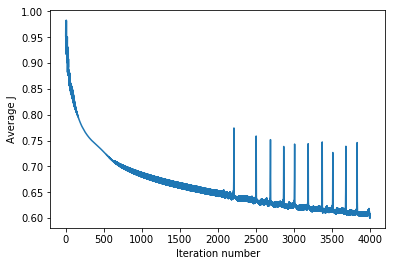

In [218]:
#Prediction Accuracy of 47.57449757449758%
#Second Itteratin with 50000 had 49.549549549549546%
#This is actually a fairly solid result
#It's a result that looks like it could do slightly better with more itterations
plt.plot(Model_Params['ReLU'][2])
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.savefig('First_Neural_Net.png')
plt.show()

# Summarizing

In [232]:
acc_df = pd.DataFrame()
column = ['S&P 500', 'EUR/USD','GOLD','Treas_Bond','Test Accuracy', 'Train Accuracy']
ind = ['Sigmoid','TanH','ReLU']
acc_df = pd.DataFrame(index = ind, columns = column)
acc_df['S&P 500'][0] = Model_Test_Classification['Sigmoid'][0.0]
acc_df['S&P 500'][1] = Model_Test_Classification['TanH'][0.0]
acc_df['S&P 500'][2] = Model_Test_Classification['ReLU'][0.0]
acc_df['EUR/USD'][0] = Model_Test_Classification['Sigmoid'][1.0]
acc_df['EUR/USD'][1] = Model_Test_Classification['TanH'][1.0]
acc_df['EUR/USD'][2] = Model_Test_Classification['ReLU'][1.0]
acc_df['Treas_Bond'][0] = Model_Test_Classification['Sigmoid'][3.0]
acc_df['Treas_Bond'][1] = Model_Test_Classification['TanH'][3.0]
acc_df['Treas_Bond'][2] = Model_Test_Classification['ReLU'][3.0]
acc_df['GOLD'][0] = Model_Test_Classification['Sigmoid'][2.0]
acc_df['GOLD'][1] = Model_Test_Classification['TanH'][2.0]
acc_df['GOLD'][2] = Model_Test_Classification['ReLU'][2.0]
acc_df['Test Accuracy'][0] = Accuracy['Sigmoid'][0]
acc_df['Test Accuracy'][1] = Accuracy['TanH'][0]
acc_df['Test Accuracy'][2] = Accuracy['ReLU'][0]
acc_df['Train Accuracy'][0] = Accuracy['Sigmoid'][1]
acc_df['Train Accuracy'][1] = Accuracy['TanH'][1]
acc_df['Train Accuracy'][2] = Accuracy['ReLU'][1]

In [233]:
acc_df

,S&P 500,EUR/USD,GOLD,Treas_Bond,Test Accuracy,Train Accuracy
Sigmoid,1289,1167,21,409,0.347193,0.350806
TanH,584,1520,200,582,0.424809,0.436839
ReLU,577,779,745,785,0.615385,0.664703


In [228]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_vect,y_relu_pred)
Csum = np.sum(C,axis=0)
Cnorm = C / Csum[None,:]
#Print Best models confusion matrix
ind = ['S&P 500', 'EUR/USD','GOLD','Treas_Bond']
column = ['S&P 500', 'EUR/USD','GOLD','Treas_Bond']
conf_mat = pd.DataFrame(index = ind, columns = column, data = Cnorm)
conf_mat

[[0.56672444 0.03465982 0.28456376 0.21528662]
 [0.05025997 0.80231065 0.01073826 0.03949045]
 [0.24610052 0.00256739 0.56241611 0.22929936]
 [0.13691508 0.16046213 0.14228188 0.51592357]]


In [193]:
Model_Params.keys()

dict_keys(['TanH', 'Sigmoid'])

In [190]:
Model_Test_Classification

{'Sigmoid': {0.0: 1289, 1.0: 1167, 2.0: 21, 3.0: 409},
 'TanH': {0.0: 584, 1.0: 1520, 2.0: 200, 3.0: 582}}

# Applying Bitcoin Returns to the Best NN

In [119]:
#Importing Bitcoin DataSet
btc = pd.read_csv("BTC_Final.csv")
btc.set_index('Date',inplace = True)
print(btc.shape)
btc.head()

(3200, 2)


,BTC_Close,BTC_Volume
Date,,
2010-07-17,0.550310,-0.374477
2010-07-18,-0.060508,-0.374477
2010-07-19,-0.077962,-0.374477
2010-07-20,0.058087,-0.374477
2010-07-21,-0.450129,-0.374477


In [120]:
btc_arima = pd.read_csv("BTC_Arima_Residuals.csv")
btc_arima.set_index('Date', inplace = True)
btc_arima.head()

,BTC_Res
Date,
2014-05-17,-0.005870
2014-05-18,-0.014000
2014-05-19,0.087373
2014-05-20,0.009015
2014-05-21,0.055924


In [121]:
num_days = 20
for column in btc:
    col_array = btc[column].values
    data_matrix = np.zeros((btc.shape[0] - num_days + 1)*num_days).reshape((btc.shape[0] - num_days + 1,num_days))
    for i in range(0, btc.shape[0] - num_days + 1):
        data_matrix[i,:] = col_array[i:i+num_days]
    data_dict[column] = data_matrix

In [122]:
#For Arima
num_days = 20
for column in btc_arima:
    col_array = btc_arima[column].values
    data_matrix = np.zeros((btc_arima.shape[0] - num_days + 1)*num_days).reshape((btc_arima.shape[0] - num_days + 1,num_days))
    for i in range(0, btc_arima.shape[0] - num_days + 1):
        data_matrix[i,:] = col_array[i:i+num_days]
    data_dict[column] = data_matrix

In [123]:
print(data_dict['BTC_Close'][1400:].shape)
print(data_dict['BTC_Res'].shape)

(1781, 20)
(1781, 20)


In [124]:
asset_dict['btc'] = np.hstack((data_dict['BTC_Close'][1400:],data_dict['BTC_Volume'][1400:],data_dict['BTC_Res']))

In [234]:
btc_pred = predict_y(Model_Params['ReLU'][0], Model_Params['ReLU'][1], asset_dict['btc'], 3)
print(btc_pred)

[3. 3. 3. ... 0. 0. 1.]


In [235]:
unique, counts = np.unique(btc_pred, return_counts = True)

In [236]:
btc_class_dict = dict(zip(unique,counts))
print(btc_class_dict)
#We actually have relatively conclusive results

{0.0: 236, 1.0: 1071, 2.0: 34, 3.0: 440}


# Putting it all together

In [237]:
#ReLU Classifier Table
btc_class_df = pd.DataFrame()
column = ['S&P 500', 'EUR/USD','GOLD','Treas_Bond']
ind = ['ReLU Classification']
btc_class_df = pd.DataFrame(index = ind, columns = column)
btc_class_df['S&P 500'] = btc_class_dict[0.0]
btc_class_df['EUR/USD'] = btc_class_dict[1.0]
btc_class_df['GOLD'] = btc_class_dict[2.0]
btc_class_df['Treas_Bond'] = btc_class_dict[3.0]


In [239]:
btc_class_df/1781

,S&P 500,EUR/USD,GOLD,Treas_Bond
ReLU Classification,0.13251,0.601348,0.01909,0.247052
